In [1]:
import os
import json
import random
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import time
import pickle

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SEED = 5
random.seed(SEED)
torch.manual_seed(SEED)

In [4]:
class GRU(nn.Module):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def __init__(self):
        super(GRU, self).__init__()
        
        self.gru = nn.GRU(input_size=4, hidden_size=48, num_layers=2)
        self.dropout = nn.Dropout(0.1)

        self.Linear = nn.Linear(48+2, 1)

        self.cnnLayer = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), 
        nn.BatchNorm2d(64),
        nn.GELU(),
        nn.MaxPool2d((3,3)))

        
    def forward(self, X, space_data):
        z = torch.zeros([X.shape[0], 144, X.shape[1]])
        z = z.to(device)

#         print(X.shape)
#         print(z)
#         print(type(x))
#         print(type(X))
#         print(type(z))
        x = torch.concat((torch.transpose(X,2,1),z), axis=1)
#         print(1)
        out1, _ = self.gru(x)
        ou1 = self.dropout(out1)

        cnn_out = self.cnnLayer(space_data)
        cnn_out = torch.reshape(cnn_out, (cnn_out.shape[0], 288, -1))

        out2 = self.Linear(torch.concat((out1, cnn_out), 2))

       
        return out2

In [13]:
# import pandas as pd
# import numpy as np

# def get_NA_index(df):
#     nan_cond = pd.isna(df).any(axis=1)
#     invalid_cond = (df['Patv'] < 0) | \
#                    ((df['Patv'] == 0) & (df['Wspd'] > 2.5)) | \
#                    ((df['Pab1'] > 89) | (df['Pab2'] > 89) | (df['Pab3'] > 89)) | \
#                    ((df['Wdir'] < -180) | (df['Wdir'] > 180) | (df['Ndir'] < -720) |
#                     (df['Ndir'] > 720))
#     indices_na = np.where(nan_cond | invalid_cond)
#     indices_right = np.where(~nan_cond & ~invalid_cond)
#     return list(indices_na[0]), list(indices_right[0])


def get_diff(row):
    diff = np.array(row['Etmp_seq']) - np.array(row['Itmp_seq'])
    return list(diff)

In [6]:
class myDataset_gru(Dataset):
    def __init__(self, df):

        self.seq_list1 = list(df['Wspd_seq'])
        self.seq_list2 = list(df['Patv_seq'])
        
        self.seq_list3 = list(df['Etmp_seq'])
        self.seq_list4 = list(df['Itmp_seq'])
        
        self.seq_list5 = list(df['Patv_space'])

        
        self.label_list = df.target.values

    def __getitem__(self, index):
        
        seq = np.vstack((self.seq_list1[index], self.seq_list2[index], self.seq_list3[index], self.seq_list4[index]))
        seq = np.array(seq).astype('float') 
        
        image = np.array(self.seq_list5[index]).astype('float') 
        image.resize(11, 11, 1)

        label = np.array( self.label_list[index] ).astype( 'float' )
        
        seq = torch.tensor(seq, device = 'cuda')
        space_data = torch.tensor(image, device = 'cuda')

        return seq, space_data, label


    def __len__(self):
        return len(self.seq_list1)

In [8]:
def pred_gru(model, test_loader,device):
    model.to(device)
    model.eval()

    pred_list = []

    for seq, space_data, label in tqdm(test_loader):
        seq = seq.type(torch.float32).to(device)
        space_data = torch.reshape(space_data, (-1,1,11,11 )).to(device)
        space_data = space_data.type(torch.float32)
        label = label.type(torch.float32).to(device)

        pred = model(seq, space_data)

        pred_list.extend(pred.squeeze().cpu().detach().numpy())

    return pred_list

In [10]:
def forecast():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    
    
    test_x = pd.read_csv("train_dataf.csv")
    test_x = test_x.fillna(0)
    test_x = test_x.sort_values(['TurbID','Day','Tmstamp'], ascending=True).reset_index(drop=True)
    
    model = GRU()

    model.load_state_dict(torch.load('ourbest2batch32shuffleF3sin_data_normal_lr05scaling22yeswspdscale.pdparams'))
    


    path_to_distdict = 'dist_dict.pickle'
    with open(path_to_distdict, 'rb') as f:
        dist_dict = pickle.load(f)
        
    df_group = test_x[['Day','Tmstamp','Patv']].groupby(['Day','Tmstamp'], as_index=False).agg(list)
    print(df_group)
    df_group.columns = ['Day','Tmstamp','Patv_list']

    for turbid in range(134):        
        
        turb_data = test_x[test_x['TurbID']==turbid+1].reset_index(drop=True)
        turb_data = pd.merge(turb_data, df_group, how='left', on=['Day','Tmstamp'])
        turb_data['Patv_space'] = turb_data['Patv_list'].apply(lambda x: [x[i-1] for i in dist_dict[turbid+1][:121]])
    
        df_test = pd.DataFrame({'Wspd_seq':[list(turb_data['Wspd'])[-144:]],
                               'Patv_seq':[list(turb_data['Patv'])[-144:]],
                               'Etmp_seq':[list(turb_data['Etmp'])[-144:]],
                               'Itmp_seq':[list(turb_data['Itmp'])[-144:]],
                               'Pab1_seq':[list(turb_data['Pab1'])[-144:]],
                                'Patv_space':[list(turb_data['Patv_space'])[-1]],
                               'target': [[0]*288]})

        df_test['Temp_seq'] = df_test.apply(get_diff, axis=1)
        if turbid==0:
            test_new = df_test.copy()
        else:
            test_new = pd.concat([test_new, df_test])   
        

    test_dataset = myDataset_gru(test_new)
    test_loader = DataLoader(test_dataset,
                             batch_size=32,
                             shuffle=False,
                             num_workers=0)
                             
    pred_list = pred_gru(model,test_loader,device)

    return pred_list


In [14]:
answer = forecast()

       Day Tmstamp                                               Patv
0        1   00:00  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        1   00:10  [494.66, 449.83, 485.38, 481.5, 488.08, 469.4,...
2        1   00:20  [509.76, 449.67, 511.89, 482.83, 487.95, 509.2...
3        1   00:30  [542.53, 474.48, 472.35, 516.06, 526.32, 539.5...
4        1   00:40  [509.36, 457.9, 500.94, 484.15, 485.96, 480.6,...
...    ...     ...                                                ...
31963  222   23:10  [129.69, 115.18, 78.33, 96.46, 87.04, 98.79, 9...
31964  222   23:20  [84.23, 110.93, 43.59, 83.67, 94.73, 88.29, 82...
31965  222   23:30  [49.39, 75.08, -0.3, 95.22, 88.77, 103.38, 100...
31966  222   23:40  [-0.33, -0.32, 117.37, -0.32, -0.32, 117.4, 13...
31967  222   23:50  [86.99, -0.3, 79.99, 33.14, 79.87, 167.46, 113...

[31968 rows x 3 columns]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.42s/it]


In [15]:
answer

[array([271.79132 , 274.05246 , 267.43445 , 260.70648 , 262.71274 ,
        258.31122 , 291.65048 , 279.15335 , 248.54803 , 267.96307 ,
        268.10583 , 271.25113 , 253.4519  , 262.2161  , 268.17014 ,
        263.67807 , 279.1934  , 265.84824 , 260.4411  , 291.57028 ,
        250.40057 , 191.70332 , 147.1883  , 159.73149 , 120.97754 ,
        154.48727 , 102.94507 ,  97.47415 , 138.44954 ,  81.33047 ,
         64.766945, 167.46964 , 179.57993 , 189.71426 , 160.48814 ,
         63.51152 , 109.97378 , 194.35379 , 184.73627 , 184.27858 ,
        199.4575  , 184.58548 , 248.74628 , 268.6901  , 214.44293 ,
        178.30527 , 268.27844 , 267.2905  , 274.2114  , 266.91568 ,
        241.89706 , 250.50047 , 257.6389  , 169.03886 , 136.40909 ,
         81.00084 ,  92.02403 ,  84.09181 , 154.8689  , 192.60559 ,
        171.41338 , 133.26012 ,  88.11058 ,  91.26794 , 145.34087 ,
        191.26794 , 156.22966 , 218.19962 , 232.2651  , 235.36986 ,
        245.78415 , 250.06956 , 262.34637 , 254.

In [16]:
b = np.array(answer).flatten().tolist()

In [17]:
np.mean(b)

258.52028089396003

In [18]:
np.mean(list(np.array(b)*361/248))

376.31379597870796

In [19]:
import matplotlib.pyplot as plt

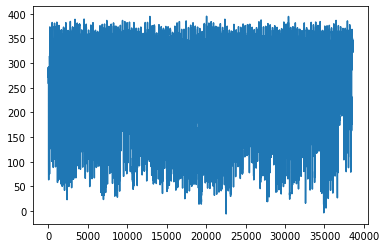

In [21]:
plt.plot(list(np.array(b)))

In [30]:
raw_data = pd.read_csv("train_dataf.csv")
raw_data = raw_data.dropna()

In [31]:
result = []
for k,v in raw_data.groupby('Day'):
    result.append([k, max(v['Patv']), min(v['Patv']), np.median(v['Patv']) ,np.mean(v['Patv']) , np.var(v['Patv'])  ])
print(pd.DataFrame(result, columns=['Day', 'min', 'max','median', 'mean', 'var']))

     Day      min   max    median        mean            var
0      1  1550.74 -5.05   417.840  480.429500  113511.924098
1      2  1549.98 -5.53   199.235  297.549172  115234.653742
2      3  1550.17 -1.15  1055.365  980.730066  179370.423352
3      4  1549.99 -0.34   563.540  626.811118  257139.524506
4      5  1550.32 -9.31   406.430  525.498332  259768.439699
..   ...      ...   ...       ...         ...            ...
216  218  1046.64 -7.00   175.185  223.950183   40268.354976
217  219   430.06 -8.55     0.000   63.878392    8228.631263
218  220   900.71 -6.67    -0.300   71.721942   17517.387697
219  221  1559.90 -0.31   446.110  548.213966  130872.716553
220  222  1520.04 -5.29   291.555  334.013728   86691.169960

[221 rows x 6 columns]


In [32]:
dat = pd.DataFrame(result, columns=['Day', 'min', 'max','median', 'mean', 'var'])

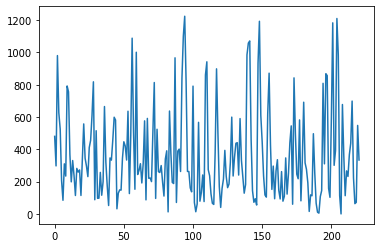

In [33]:
plt.plot(dat['mean'])

In [34]:
sample_submission = pd.read_csv("sample_submissionf.csv")

In [35]:
sample_submission

,index,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,0,1,223,00:00,0,0,0,0,0,0,0,0,0,0
1,1,1,223,00:10,0,0,0,0,0,0,0,0,0,0
2,2,1,223,00:20,0,0,0,0,0,0,0,0,0,0
3,3,1,223,00:30,0,0,0,0,0,0,0,0,0,0
4,4,1,223,00:40,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38587,38587,134,224,23:10,0,0,0,0,0,0,0,0,0,0
38588,38588,134,224,23:20,0,0,0,0,0,0,0,0,0,0
38589,38589,134,224,23:30,0,0,0,0,0,0,0,0,0,0
38590,38590,134,224,23:40,0,0,0,0,0,0,0,0,0,0


In [36]:
sample_submission["Patv"] = list(np.array(b)*130/258.6069819560741) #65 75 130 73 
sample_submission.to_csv("./hs_submit130wind5.csv", index = False)